In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

In [40]:
current_directory = os.getcwd()
print("Current Working Directory:", current_directory) # To reset wd to default one

Current Working Directory: /Users/samuele/Documents/Università/Magistrale/Corsi/HPC/FHPC_Assignment/Exercise2/EPYC/cores


In [41]:
# CODE TO CHECK IF ANY FILE HAS MISSING VALUES (Could happen by error)
folder_path = "spread"  
files_less_than_5_rows = []
files_more_than_5_rows = []
files_with_incomplete_rows = {}  # Use a dictionary to store filename: number of incomplete rows

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            df = pd.read_csv(file_path)
            num_rows = df.shape[0]
            if num_rows < 5:
                files_less_than_5_rows.append(filename)
            elif num_rows > 5:
                files_more_than_5_rows.append(filename)
            
            # Check for incomplete rows (rows with missing values)
            num_incomplete_rows = df.isnull().any(axis=1).sum()
            if num_incomplete_rows > 0:
                files_with_incomplete_rows[filename] = num_incomplete_rows
        except Exception as e:
            print(f"Error processing {filename}: {e}")

print("Files with less than 5 rows:")
for filename in files_less_than_5_rows:
    print(filename)

print("\nFiles with more than 5 rows:")
for filename in files_more_than_5_rows:
    print(filename)

print("\nFiles with incomplete rows:")
for filename, num_incomplete_rows in files_with_incomplete_rows.items():
    print(f"{filename} - Number of incomplete rows: {num_incomplete_rows}")


Files with less than 5 rows:

Files with more than 5 rows:

Files with incomplete rows:


## Analysis of results for increasing number of cores

In [42]:
methods = ['mkl', 'oblas', 'blis']
precision = ['float', 'double']
placement = ['close', 'spread'] # Poi ci sarà da aggiungere master

In [43]:
df = pd.DataFrame(columns=['n_threads', 'Time', 'GFLOPS', 'precision', 'method', 'placement'])
df

,n_threads,Time,GFLOPS,precision,method,placement


In [44]:
for pl in placement:
    for m in methods:
        for prec in precision:
            file_pattern = f"{pl}/{m}_{prec}_*.csv"

            # Get a list of file paths matching the pattern
            file_paths = glob.glob(file_pattern)
            #print(f"file_pattern matches {len(file_paths)} paths")

            # Initialize an empty list to store DataFrames
            dfs = []

            # Loop through each file and read it into a DataFrame, then add it to the list
            for file_path in file_paths:
                df_temp = pd.read_csv(file_path)
                dfs.append(df_temp)

            # Concatenate all DataFrames in the list into a single DataFrame
            df_temp = pd.concat(dfs, ignore_index=True)
            df_temp['precision'] = prec
            df_temp['method'] = m
            df_temp['placement'] = pl

            # Display the combined DataFrame
            df = pd.concat([df, df_temp])

In [45]:
df

,n_threads,Time,GFLOPS,precision,method,placement
0,116,1.518031,1317.495909,float,mkl,close
1,116,1.497978,1335.133357,float,mkl,close
2,116,1.442370,1386.607213,float,mkl,close
3,116,1.526470,1310.212271,float,mkl,close
4,116,1.573038,1271.425043,float,mkl,close
...,...,...,...,...,...,...
320,84,2.500122,799.960902,double,blis,spread
321,84,2.545064,785.834977,double,blis,spread
322,84,2.535879,788.681294,double,blis,spread
323,84,2.513537,795.691453,double,blis,spread


# Double Precision
In this case the theoretical peak performance is given by 2.6 * 16 * n_threads

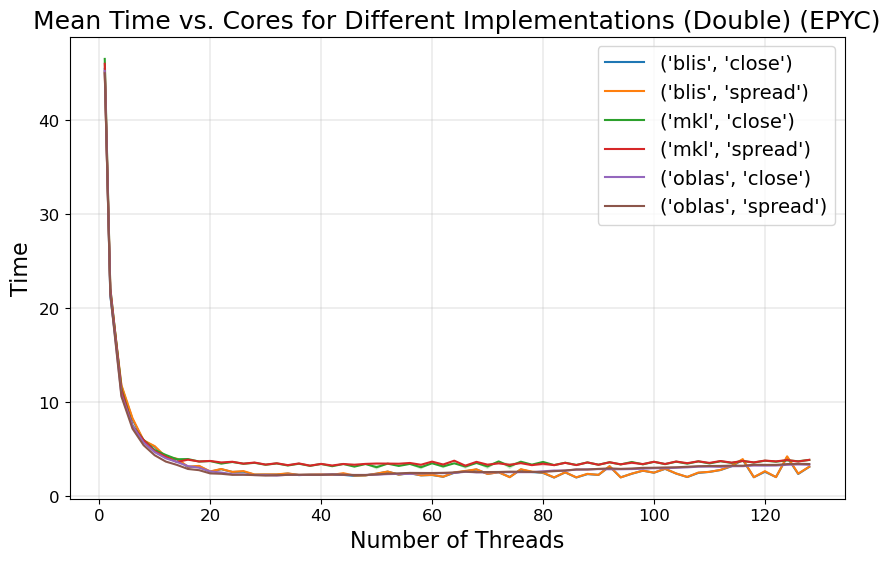

In [46]:
grouped_double = df[df['precision']=='double']
grouped_double.drop(columns=['precision'])

grouped_double = grouped_double.groupby(['method', 'placement', 'n_threads'])


# Calculate the mean, minimum, and maximum of 'Time' for each group
agg_df = grouped_double['Time'].agg(['mean', 'min', 'max', 'std']).reset_index()

# Create a figure and axis
plt.figure(figsize=(10, 6))
for name, group in agg_df.groupby(['method', 'placement']):
    plt.plot(group['n_threads'], group['mean'], label=name)
    plt.fill_between(group['n_threads'],
                     group['mean'] - group['std'],
                     group['mean'] + group['std'],
                     alpha=0.2)

# Add labels and title
plt.xlabel('Number of Threads', fontsize = 16)
plt.ylabel('Time', fontsize = 16)
plt.title('Mean Time vs. Cores for Different Implementations (Double) (EPYC)', fontsize = 18)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend
plt.legend(fontsize=14)

# Show the plot
plt.grid(linewidth = 0.3)
plt.show()

In [47]:
def calculate_speedup(group):
    group['speedup'] =  group['mean'].iloc[0] / group['mean']
    return group


agg_df2 = agg_df.groupby(['method', 'placement'], group_keys=False).apply(calculate_speedup).reset_index(drop=True)

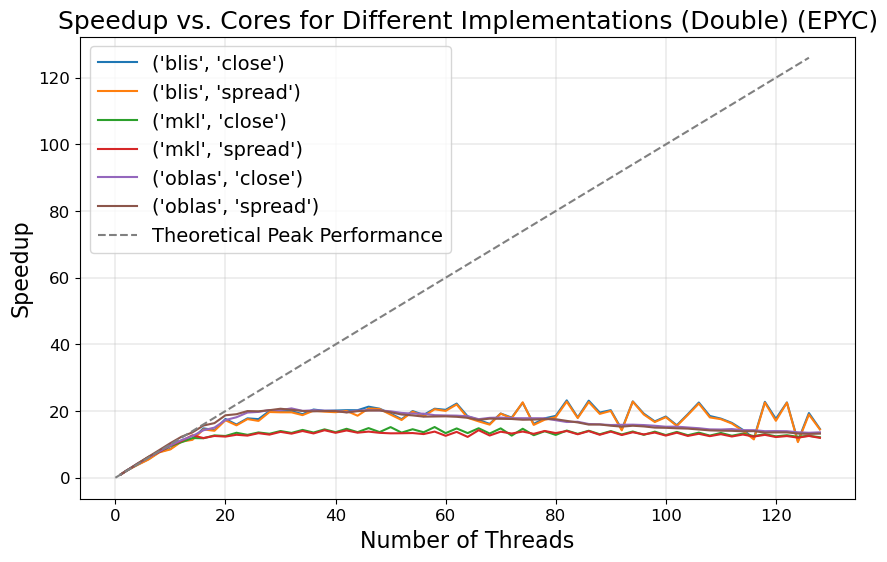

In [48]:
# Create a figure and axis
plt.figure(figsize=(10, 6))
for name, group in agg_df2.groupby(['method', 'placement']):
    plt.plot(group['n_threads'], group['speedup'], label=name)
# Add labels and legend
# Add labels and title

x_values = np.arange(0, 128, 2)
plt.plot(x_values, x_values, c = "gray", linestyle="dashed", label="Theoretical Peak Performance")

plt.xlabel('Number of Threads', fontsize = 16)
plt.ylabel('Speedup', fontsize = 16)
plt.title('Speedup vs. Cores for Different Implementations (Double) (EPYC)', fontsize = 18)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend
plt.legend(fontsize=14)

# Show the plot
plt.grid(linewidth = 0.3)
plt.show()

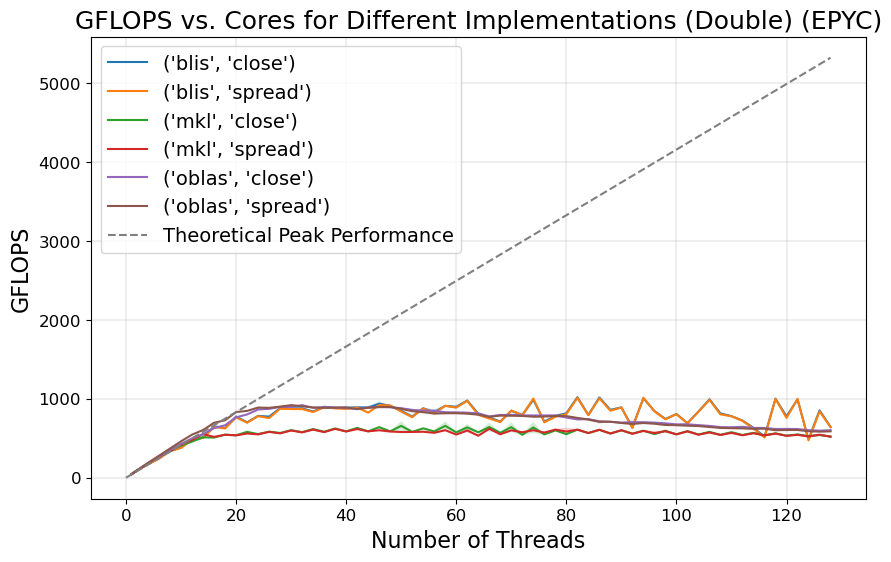

In [49]:
grouped_double = df[df['precision']=='double']
grouped_double.drop(columns=['precision'])

grouped_double = grouped_double.groupby(['method', 'placement', 'n_threads'])


# Calculate the mean, minimum, and maximum of 'Time' for each group
agg_df = grouped_double['GFLOPS'].agg(['mean', 'min', 'max', 'std']).reset_index()

# Create a figure and axis
plt.figure(figsize=(10, 6))
for name, group in agg_df.groupby(['method', 'placement']):
    plt.plot(group['n_threads'], group['mean'], label=name)
    plt.fill_between(group['n_threads'],
                     group['mean'] - group['std'],
                     group['mean'] + group['std'],
                     alpha=0.2)
    
plt.plot(np.arange(0, 130, 2), 2.6*16*np.arange(0, 130, 2), c = 'gray', label = "Theoretical Peak Performance", linestyle='dashed')

plt.xlabel('Number of Threads', fontsize = 16)
plt.ylabel('GFLOPS', fontsize = 16)
plt.title('GFLOPS vs. Cores for Different Implementations (Double) (EPYC)', fontsize = 18)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend
plt.legend(fontsize=14)

# Show the plot
plt.grid(linewidth = 0.3)
plt.show()

- - - 


# Single/Float Precision
In this case the theoretical peak performance is given by 2.6 * 32 * n_threads

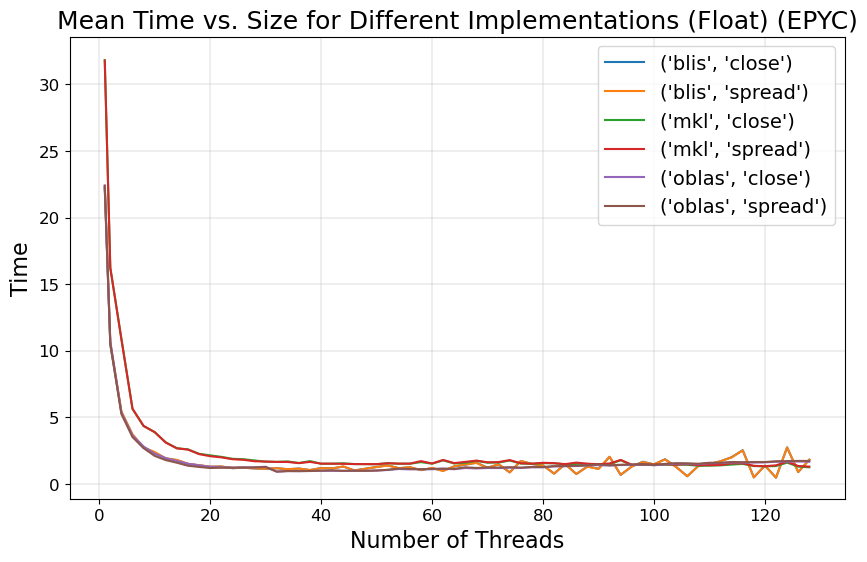

In [50]:
grouped_float = df[df['precision']=='float']
grouped_float.drop(columns=['precision'])

grouped_float = grouped_float.groupby(['method', 'placement', 'n_threads'])


# Calculate the mean, minimum, and maximum of 'Time' for each group
agg_df = grouped_float['Time'].agg(['mean', 'min', 'max', 'std']).reset_index()

# Create a figure and axis
plt.figure(figsize=(10, 6))
for name, group in agg_df.groupby(['method', 'placement']):
    plt.plot(group['n_threads'], group['mean'], label=name)
    plt.fill_between(group['n_threads'],
                     group['mean'] - group['std'],
                     group['mean'] + group['std'],
                     alpha=0.2)

# Add labels and title
plt.xlabel('Number of Threads', fontsize = 16)
plt.ylabel('Time', fontsize = 16)
plt.title('Mean Time vs. Size for Different Implementations (Float) (EPYC)', fontsize = 18)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend
plt.legend(fontsize=14)

# Show the plot
plt.grid(linewidth = 0.3)
plt.show()

In [51]:
def calculate_speedup(group):
    group['speedup'] =  group['mean'].iloc[0] / group['mean']
    return group


agg_df2 = agg_df.groupby(['method', 'placement'], group_keys=False).apply(calculate_speedup).reset_index(drop=True)

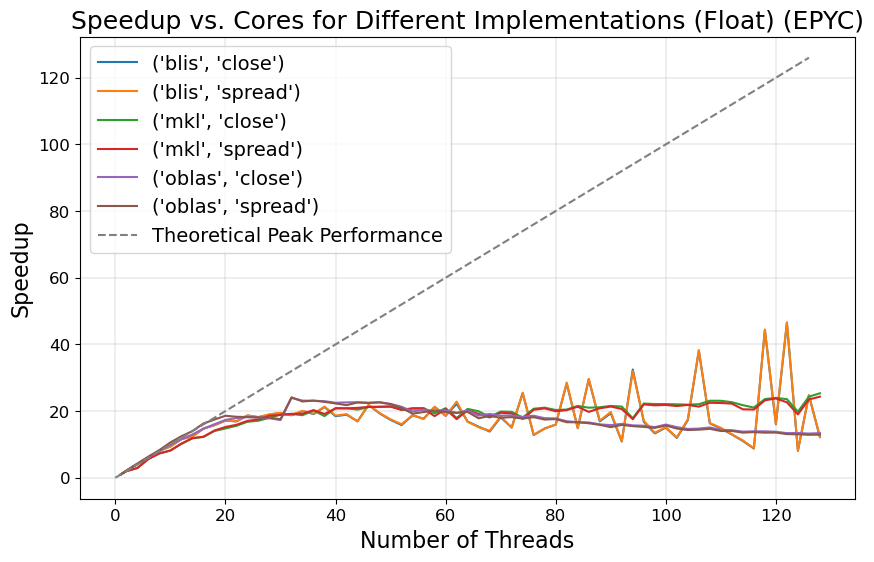

In [52]:
# Create a figure and axis
plt.figure(figsize=(10, 6))
for name, group in agg_df2.groupby(['method', 'placement']):
    plt.plot(group['n_threads'], group['speedup'], label=name)
# Add labels and legend
# Add labels and title

x_values = np.arange(0, 128, 2)
plt.plot(x_values, x_values, c = "gray", linestyle="dashed", label="Theoretical Peak Performance")

plt.xlabel('Number of Threads', fontsize = 16)
plt.ylabel('Speedup', fontsize = 16)
plt.title('Speedup vs. Cores for Different Implementations (Float) (EPYC)', fontsize = 18)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend
plt.legend(fontsize=14)

# Show the plot
plt.grid(linewidth = 0.3)
plt.show()

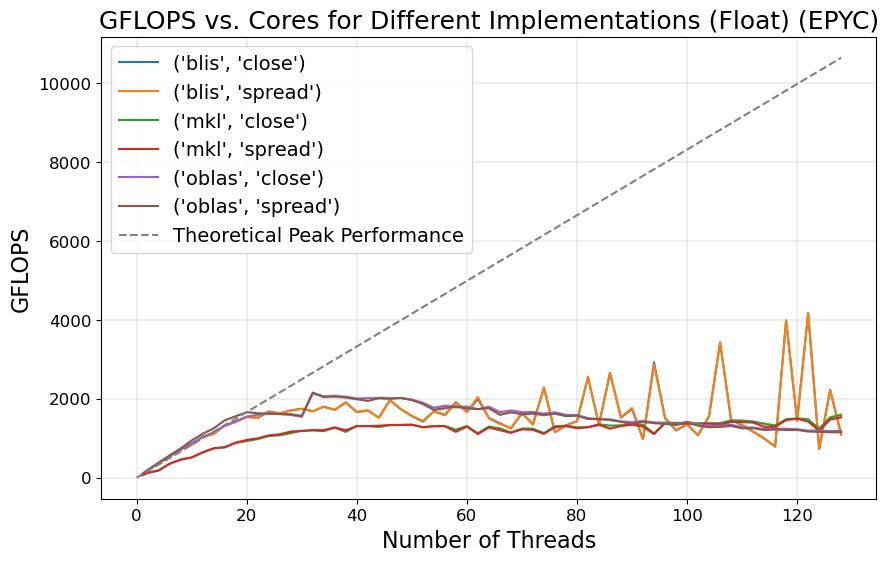

In [53]:
grouped_float = df[df['precision']=='float']
grouped_float.drop(columns=['precision'])

grouped_float = grouped_float.groupby(['method', 'placement', 'n_threads'])


# Calculate the mean, minimum, and maximum of 'Time' for each group
agg_df = grouped_float['GFLOPS'].agg(['mean', 'min', 'max', 'std']).reset_index()

# Create a figure and axis
plt.figure(figsize=(10, 6))
for name, group in agg_df.groupby(['method', 'placement']):
    plt.plot(group['n_threads'], group['mean'], label=name)
    plt.fill_between(group['n_threads'],
                     group['mean'] - group['std'],
                     group['mean'] + group['std'],
                     alpha=0.2)
    
plt.plot(np.arange(0, 130, 2), 2*2.6*16*np.arange(0, 130, 2), c = 'gray', label = "Theoretical Peak Performance", linestyle='dashed')

plt.xlabel('Number of Threads', fontsize = 16)
plt.ylabel('GFLOPS', fontsize = 16)
plt.title('GFLOPS vs. Cores for Different Implementations (Float) (EPYC)', fontsize = 18)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend
plt.legend(fontsize=14)

# Show the plot
plt.grid(linewidth = 0.3)
plt.show()